In [1]:
import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general
import torch
from torchvision import transforms
from PIL import Image
import random
import itertools

c:\Users\marti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
img_list, names = lrne.load_name_and_img("cropped_mean/*jpeg")

In [3]:
print(len(img_list))
print(len(names))

4915
4915


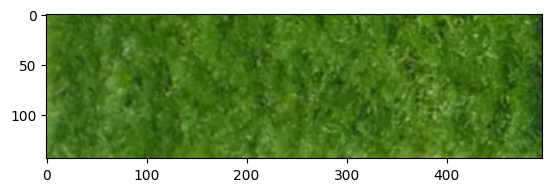

cropped_mean\162_200528_Min.jpeg


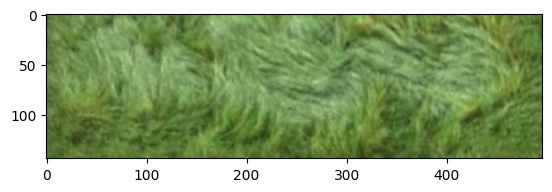

cropped_mean\100_160607_Min.jpeg


In [4]:
# pick a random index
random_index = random.randint(0, len(img_list)-1)

# get the corresponding image and name
random_img = img_list[random_index]
random_name = names[random_index]

# show the image and print the name
plt.imshow(random_img)
plt.show()
print(random_name)

# show the first image and print the name
plt.imshow(img_list[0])
plt.show()
print(names[0])


In [5]:
date_ = False
bin_size = 10
n_bins = int(np.floor(100/bin_size))
labels = svm_general.load_labels(bin_size, date_)
print(labels[0])
print(len(labels))

#convert names into [flight_folder, ROI]
names_labels = lrne.it_name_extract_labels_from_img_jpeg(names)
print(names_labels[0])
lodging_score = [[] for _ in range(4915)]

#match labels with feature names
lodging_score = svm_general.match_pic_label_to_names_new(lodging_score, labels, names_labels, date_)

['103' '35' '160607_Min' '3']
4936
['100', '160607_Min']


In [6]:
lodging_score_int = [[int(char) for char in sublist] for sublist in lodging_score]
flattened_list = list(itertools.chain.from_iterable(lodging_score_int))
#print(flattened_list)
lodging_score = flattened_list
#print(max(lodging_score_int))
count_9 = lodging_score.count(9)
print(count_9)

print(np.shape(img_list))
print(np.shape(flattened_list))

1
(4915, 144, 496, 3)
(4915,)


In [7]:
import torch

def list_gpu_names():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            print(f"GPU {i}: {gpu_name}")
    else:
        print("No GPUs available on this machine.")

# Call the function to list GPU names
list_gpu_names()

from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2070 SUPER
GPU 1: NVIDIA GeForce GTX 1050 Ti
cuda:0


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, img_list, lodging_score, transform=None):
        self.img_list = img_list
        self.lodging_score = lodging_score
        self.transform = transform
        self.mean = 0
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        score = self.lodging_score[idx]

        # Convert image to tensor and apply transformations
        if self.transform:
            img = self.transform(img)

        return img, score
    def get_labels(self):
        return self.lodging_score

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 496)),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

#print(dataSet[0][0].mean(dim=-1))


In [9]:
from random import shuffle
# Combine img_list and lodging_score
combined_data = list(zip(img_list, lodging_score))

# Shuffle the combined data
shuffle(combined_data)

# Unzip the shuffled data
img_list, lodging_score = zip(*combined_data)
dataSet = ImageDataset(img_list, lodging_score, transform=transform)
print(dataSet[0][1])
count_0 = lodging_score.count(0)
print(count_0)


3
2314


In [10]:
#Keep only 500 zeros in the dataset. In attempt to balance the dataset where the zeors are the majority by far.
def filter_data(dataSet):
    filtered_data = []
    count = 0
    for data in dataSet:
        if data[1] == 0 and count < 500:
            filtered_data.append(data)
            count += 1
        elif data[1] != 0 and data[1] != 9:
            filtered_data.append(data)
    return filtered_data
dataSet = filter_data(dataSet)
print(len(dataSet[0]))
print(len(dataSet))
print(dataSet[0][0].shape)


2
3100
torch.Size([1, 300, 300])


In [11]:

def augment_data(dataSet):
    horizontal_flip = transforms.RandomHorizontalFlip(p=1.0)  # Set probability to 1.0 for always flipping
    vertical_flip = transforms.RandomVerticalFlip(p=1.0)  # Set probability to 1.0 for always flipping
    augmented_data = []
    transform1 = transforms.Compose([
        transforms.ToPILImage(),
    ])
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    for data in dataSet:
        img, label = data
        augmented_img = horizontal_flip(img)
        augmented_data.append((augmented_img, label))
        augmented_img = vertical_flip(img)
        augmented_data.append((augmented_img, label))
        augmented_img = vertical_flip(horizontal_flip(img))
        augmented_data.append((augmented_img, label))
        augmented_data.append((img, label))
        

    return augmented_data

# Usage example
augmented_dataSet = augment_data(dataSet)
dataSet = augmented_dataSet


In [12]:
print(len(dataSet[0]))
print(len(dataSet))
#print(type(dataSet[0][0]))
from IPython.display import display

# Assuming img is a PIL.Image.Image object
display(dataSet[0][0].shape)

2
12400


torch.Size([1, 300, 300])

In [13]:
#Split into train and validation set
random_seed = 10587
testValSize = (2/5) * len(dataSet)
trainDataset, testvalDataset = train_test_split(dataSet, test_size=int(testValSize), random_state=random_seed, shuffle=True)
validationSize = (1/2) * len(testvalDataset)
testDataset, valDataset = train_test_split(testvalDataset, test_size=int(validationSize), random_state=random_seed, shuffle=True)

#Create dataloaders
batchSize = 64
trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=batchSize, shuffle=True)

#Print sizes
print(len(trainDataset), len(testDataset), len(valDataset))
print(dataSet[0][0].shape)

7440 2480 2480
torch.Size([1, 300, 300])


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#We have ignored class 9 since there were only 1 image with that class. Therfore we have 9 classes.
num_classes = 9
channels = dataSet[0][0].shape[0]
height = dataSet[0][0].shape[1]
width = dataSet[0][0].shape[2]
print(channels)
print(height)
print(width)

1
300
300


In [15]:
kernel_size = 3
kernel_size1 = 3
# define network
conv1toconv2 = 16
conv2toconv3 = 12
conv3toconv4 = 6
conv4toconv5 = 3
conv5toconv6 = 6
conv6tolin1 = 3
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Takes in 3, 144, 496
        self.conv1 = nn.Conv2d(1,conv1toconv2,kernel_size, padding="same")
        self.conv2 = nn.Conv2d(conv1toconv2,conv2toconv3,kernel_size1, padding="same")
        self.conv3 = nn.Conv2d(conv2toconv3,conv3toconv4,kernel_size1, padding="same")
        self.conv4 = nn.Conv2d(conv3toconv4,conv4toconv5 ,kernel_size1, padding="same")
        self.conv5 = nn.Conv2d(conv4toconv5,conv5toconv6,kernel_size1, padding="same")
        self.conv6 = nn.Conv2d(conv5toconv6,conv6tolin1,kernel_size, padding="same")
        self.pool = nn.AvgPool2d(2,2)
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(9*31*conv6tolin1, 128)
        self.FC2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        x = self.pool(x)
        
        #print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        #print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        '''
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        '''
        x = self.flatten(x)
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        
        return x


In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
net = NeuralNetwork()
net.to(device)
print(net)
# Define the loss function
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10000000, verbose=True)

# Set the number of epochs
num_epochs = 50
totalAcc = 0
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    totalAcc = 0.0
    val_running_loss = 0.0
    val_totalAcc = 0.0
    for i, data in enumerate(trainDataloader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        #print(outputs.shape)
        #print(outputs[0])
        totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
        #print(torch.argmax(outputs, dim=1))
        #print(torch.argmax(outputs, dim=1).shape)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    for i, data in enumerate(valDataloader, 0):
        net.eval()
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = net(inputs)
        #print(outputs.shape)
        val_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
        #print(torch.argmax(outputs, dim=1))
        #print(torch.argmax(outputs, dim=1).shape)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        # Print statistics
        val_running_loss += loss.item()
    scheduler.step(val_running_loss)
    net.train()
    if epoch % 5 == 0:
        print('[%d] train loss: %.3f train acc: %.3f val loss: %.3f val acc: %.3f ' % (epoch + 1, running_loss / len(trainDataloader), totalAcc/len(trainDataset), val_running_loss / len(valDataloader), val_totalAcc/len(valDataset)))
    running_loss = 0.0
    totalAcc = 0.0
    val_running_loss = 0.0
    val_totalAcc = 0.0

print('Finished training')

NeuralNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(12, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC1): Linear(in_features=837, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=9, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x972 and 837x128)

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Assuming you have a trained model named 'model' and a DataLoader named 'dataloader'
# You also need the true labels for your dataset (ground truth)
# Ensure your dataloader returns the true labels along with the images

# Set the model to evaluation mode
net.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for i, data in enumerate(valDataloader, 0):
    net.eval()
    # Get the inputs and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)  # Assuming a classification task with softmax activation
    # Move tensors to CPU before extending lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Confusion Matrix:
[[215  75  43  16  10  12   0   1   0]
 [ 98 159  84  32  18  24  13  11   2]
 [ 58  79  68  27  23  21  11  10   4]
 [ 64  55  46  33  19  18  19  18   5]
 [ 23  38  37  22  34  28  27  21   1]
 [ 11  32  18  14  22  22  33  14   1]
 [ 16  19  22  17  17  30  73  56   9]
 [  3  15  30  15  16  21  81 125  27]
 [  0   0   2   3   5   5  18  23  43]]
Accuracy: 0.31129032258064515


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Assuming you have a trained model named 'model' and a DataLoader named 'dataloader'
# You also need the true labels for your dataset (ground truth)
# Ensure your dataloader returns the true labels along with the images

# Set the model to evaluation mode
net.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for i, data in enumerate(trainDataloader, 0):
    net.eval()
    # Get the inputs and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)  # Assuming a classification task with softmax activation
    # Move tensors to CPU before extending lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1094   71   23    8    1    7    0    0    0]
 [ 117 1153   19    3    1    3    1    2    1]
 [  47   26  787    7    0    4    3    2    0]
 [  97   66   60  630    2   11    0    1    1]
 [  44   24   29    7  561   15   10    7    0]
 [  10   13    3    0    1  520   16    2    0]
 [  10   23    5    2    1    8  702    0    2]
 [   1    5    4    1    1    0   30  802    1]
 [   0    1    1    0    0    1    3    6  320]]
Accuracy: 0.8829301075268817


In [ ]:
test_totalAcc = 0.0
test_running_loss = 0.0
for i, data in enumerate(testDataloader, 0):
    net.eval()
    # Get the inputs and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outputs = net(inputs)
    #print(outputs.shape)
    test_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
    #print(torch.argmax(outputs, dim=1))
    #print(torch.argmax(outputs, dim=1).shape)
    #print(outputs.shape)
    loss = criterion(outputs, labels)

    # Print statistics
    test_running_loss += loss.item()
print('test loss: %.3f test acc: %.3f' % (test_running_loss / len(testDataloader), test_totalAcc/len(testDataset)))
test_totalAcc = 0.0
test_running_loss = 0.0

test loss: 2.161 test acc: 0.399


In [ ]:
import matplotlib.pyplot as plt

# Extract the labels from the trainDataloader
labels = [data[1] for data in trainDataloader]


# Count the occurrences of each label
label_counts = {}
for label in labels:
    if label.item() in label_counts:
        label_counts[label.item()] += 1
    else:
        label_counts[label.item()] = 1

# Create a bar plot
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in trainDataloader')
plt.show()

RuntimeError: a Tensor with 64 elements cannot be converted to Scalar